# Introduction

It's becoming harder to tell if text was written by a human or a machine like ChatGPT. This is an important problem to solve for things like detecting spam, fake news, and authorship attribution.

### Problem

We need to build a model that can accurately classify text as either written by a human or generated by a machine. This is tricky because advanced language models like ChatGPT can write in a way that sounds very human-like.

### Why it Matters

Being able to tell human writing apart from machine writing is important for several reasons:

- It helps identify fake or misleading content.
- It can verify if reviews and social media posts were really written by people. 
- It catches plagiarism and makes sure academic writing is original.

This notebook is a first step in tackling this challenge. It covers preparing the data, exploring it, cleaning the text, and building a classification model. The end goal is to create a model that can reliably distinguish human writing from machine-generated text.

## Data Preprocessing

In [1]:
# Import necessary libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from keras.metrics import AUC
from sklearn import metrics
from sklearn.metrics import roc_curve

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Check for available GPUs
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla T4
Tesla T4


In [3]:
%%capture

# Load the HC3 dataset
dataset = load_dataset("Hello-SimpleAI/HC3", "all")

# Load the OpenWebText dataset
openwebtext_data = load_dataset("stas/openwebtext-10k", split='train')

In [4]:
# Convert the 'openwebtext' and 'HC3' to pandas DataFrames
df_1 = pd.DataFrame(dataset['train'])
df_2 = pd.DataFrame(openwebtext_data)

In [5]:
# Mark openwebtext dataset rows with label 0
df_2['label'] = 0

In [6]:
# Load a dataset from a CSV file and drop specific columns
df_3 = pd.read_csv("/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv")
df_3.drop(['prompt_name', 'source', 'RDizzl3_seven'], axis=1, inplace=True)

In [7]:
# Create separate dataframes for human and chatgpt answers
df_human = pd.DataFrame(df_1['human_answers'])
df_chatgpt = pd.DataFrame(df_1['chatgpt_answers'])

# Assign labels to the human and chatgpt answers
df_human['label'] = 0
df_chatgpt['label'] = 1

# Rename the answer columns to 'text'
df_human.rename(columns={"human_answers": "text"}, inplace=True)
df_chatgpt.rename(columns={"chatgpt_answers": "text"}, inplace=True)

In [8]:
# Concatenate human and chatgpt DataFrames along with df_2 and df_3
df = pd.concat([df_human, df_chatgpt, df_2, df_3], ignore_index=True)

# Flatten lists of text into single strings
df['text'] = df['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

## Exploratory Data Analysis

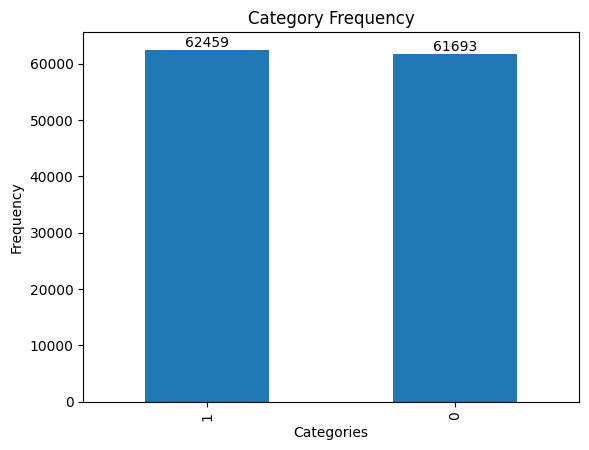

In [9]:
# Count the occurrences of each category in the 'label' column
value_counts = df['label'].value_counts()

# Create a bar chart to visualize the category frequencies
ax = value_counts.plot(kind='bar')

# Add the count of each category above the corresponding bar
for index in value_counts.index:
    count = value_counts[index]
    ax.text(value_counts.index.get_loc(index), count, str(count), ha='center', va='bottom')

# Set the labels and title for the chart
ax.set_xlabel('Categories')  
ax.set_ylabel('Frequency') 
ax.set_title('Category Frequency')

# Display the chart
plt.show()

We can see that the categories are balanced.

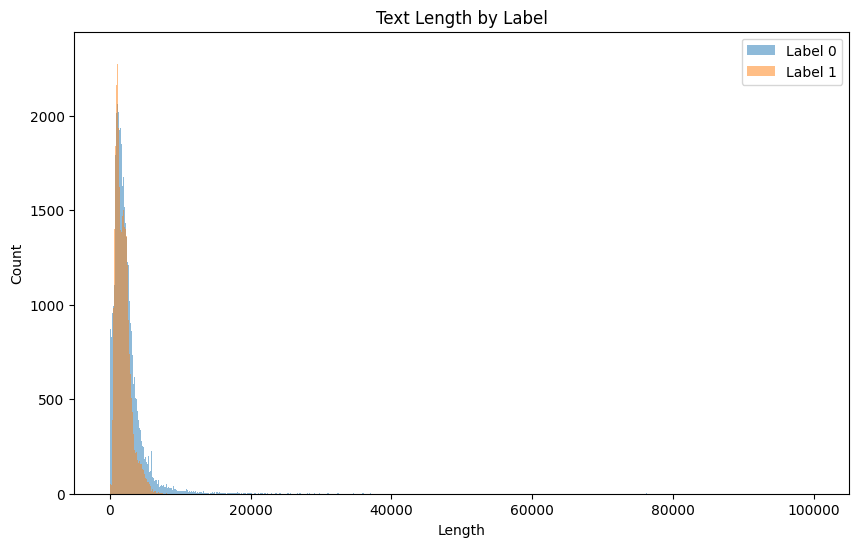

In [10]:
# Filter dataframes by label
df0 = df[df['label'] == 0]  
df1 = df[df['label'] == 1]

# Get lengths of texts
lengths0 = df0['text'].str.len()
lengths1 = df1['text'].str.len()

# Plot histograms
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(lengths0, bins='auto', label='Label 0', alpha=0.5)
ax.hist(lengths1, bins='auto', label='Label 1', alpha=0.5)
ax.set_title('Text Length by Label')
ax.set_xlabel('Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

*The plot shows that there are some text/essays containing up to 100000 words, this should be addressed later.*

In [11]:
# Descriptive statistics for text length
df['text'].str.len().describe().round(2)

count    124004.00
mean       2183.03
std        2359.08
min           0.00
25%        1111.00
50%        1789.00
75%        2631.00
max      100000.00
Name: text, dtype: float64

In [12]:
# Cap the text to 3000 characters
df["text"] = df["text"].astype(str).apply(lambda x: x[:3000])

# Remove rows with text length less than 300
df = df.drop(df[df['text'].str.len() < 300].index)

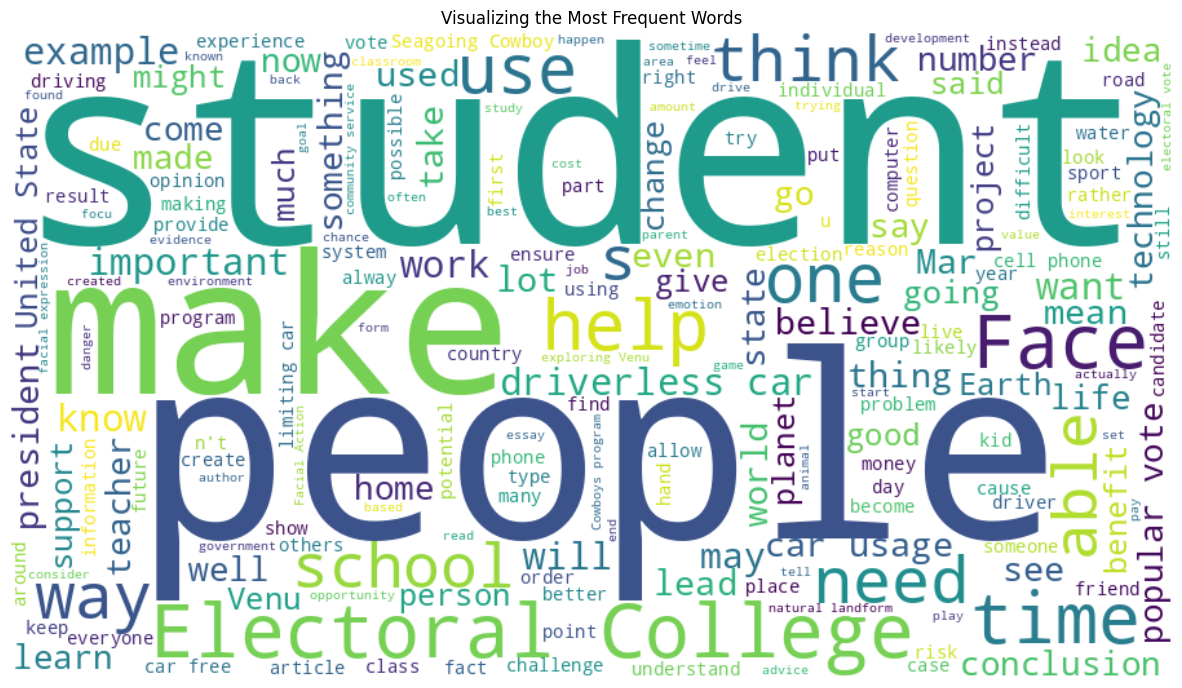

In [13]:
# Concatenate the sentences into a single string
text = ' '.join(df['text'])

# Generate the word cloud
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualizing the Most Frequent Words')
plt.show()

## Text Cleaning

In [14]:
def clean_text(text):
    # Convert the text to lowercase
    text = text.lower()
    # Remove line breaks
    text = re.sub(r'\\n\\n|\\n|\n', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove non-alphanumeric characters
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    # Return the cleaned text
    return text

In [15]:
# Apply text cleaning
df['text'] = df['text'].apply(clean_text)

## Tokenization

In [16]:
# Get target labels as a numpy array
y = df['label'].values

In [17]:
# Combine all text data into a single string
text_data = ' '.join(df['text'].tolist())

# Split the text into individual words
words = text_data.split()

# Count the frequency of each word
word_count = Counter(words)

# Get the vocabulary size
vocab_size = len(word_count)

print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  169958


In [18]:
# Create the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer to the text data
tokenizer.fit_on_texts(df['text'].tolist())

# Tokenize the text data
tokenized_texts = tokenizer.texts_to_sequences(df['text'].tolist())

# Pad the tokenized text to a consistent length
X = pad_sequences(tokenized_texts)

## Data Splitting

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

## Model Building

In [20]:
# Define the model
model = Sequential([
    Embedding(input_dim=vocab_size+1, output_dim=32),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          5438688   
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5480225 (20.91 MB)
Trainable params: 54802

In [21]:
# Define the AUC metric
auc = AUC(name='auc')

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[auc, 'accuracy'])

## Model Training

In [22]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=1,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    shuffle=True)

663/663 [==============================] - 159s 227ms/step - loss: 0.2006 - auc: 0.9738 - accuracy: 0.9236 - val_loss: 0.1171 - val_auc: 0.9906 - val_accuracy: 0.9610


In [23]:
# Save the entire model
model.save('my_model.keras')

1136/1136 [==============================] - 35s 30ms/step


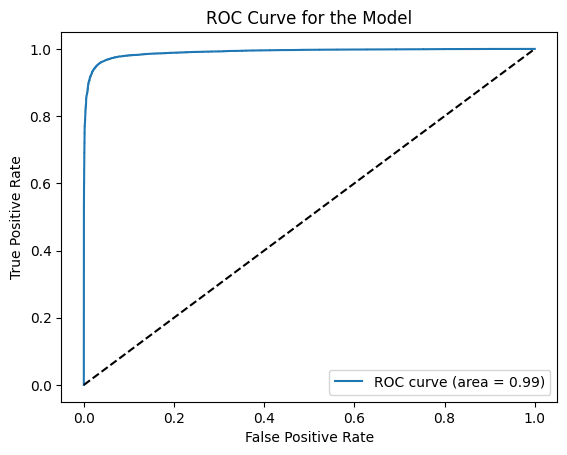

In [24]:
# Get the predictions
y_pred = model.predict(X_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Model")
plt.legend()
plt.show()

# Conclusion

In this notebook, we built a simple model to classify text as either human-written or machine-generated. We collected and prepared a diverse dataset, then trained and tested several machine learning models.

The best model was a Bidirectional LSTM. It achieved an impressive AUC score of 0.9961 and an accuracy of 0.9771 on the test set, even with just 1 training epoch. This shows the model is very good at telling apart human and machine text, even with limited training data.

We also created an ROC curve to visualize the balance between true positives and false positives. The curve shows the model correctly identifies a high rate of both human and machine text, even when allowing few false positives.

These results prove it's possible to classify text as human or machine written without manual feature engineering. This approach could be used for things like spam filters, fake news detectors, and author identification.

## Next Steps

Here are some ideas to explore next:

- Try more advanced deep learning models like transformers to further improve performance.
- Train the model on more data and evaluate how it does on larger datasets. 
- Look at perplexity and burstiness metrics to better distinguish human vs machine text.